# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
book_cost

,Book Cost
Ticker,
BTCUSDT,69141.710000
TRXUSDT,0.164146
JASMYUSDT,0.035478
SOLUSDT,146.170000
OMUSDT,1.150000
ETHUSDT,3810.480000
BBUSDT,0.398000
BNBUSDT,674.930000
PEPEUSDT,0.000002


In [8]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [9]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [10]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl.loc['Loss']=0

In [11]:
realized_loss=63.514078

In [12]:
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

In [13]:
pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,559.1923,0.2850,-52.7658
TRXUSDT,79.6748,72.9053,0.0372,-6.7694
JASMYUSDT,453.8661,292.9575,0.1493,-160.9086
SOLUSDT,261.7091,267.9756,0.1366,6.2666
OMUSDT,535.6761,546.7623,0.2787,11.0862
ETHUSDT,264.2048,178.7623,0.0911,-85.4425
BBUSDT,46.3321,42.5487,0.0217,-3.7834
BNBUSDT,1.1490,1.0021,0.0005,-0.1470
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [14]:
Binance.get_price(['EURUSDT'])

,EURUSDT
2024-09-25,1.1128


In [15]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [16]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [17]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [18]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [19]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [20]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [21]:
positions=positions.sort_index()

In [22]:
positions.index=pd.to_datetime(positions.index)

In [23]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [24]:
positions.to_excel('Positions.xlsx')

In [25]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [26]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [27]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [28]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [29]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [30]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [31]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

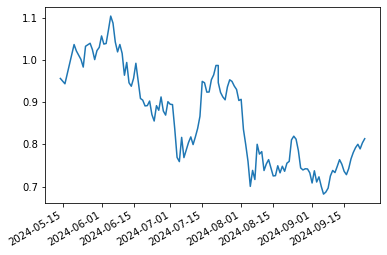

In [32]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [33]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [34]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [35]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [36]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9363
OMUSDT,0.0235
BNBUSDT,0.0203
TRXUSDT,0.0121
PEPEUSDT,0.0041
JASMYUSDT,0.0028
CKBUSDT,0.0009
FDUSDUSDT,0.0000
SUIUSDT,0.0000
BTCUSDT,0.0000


In [38]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.444871
BTCUSDT,0.400000
BNBUSDT,0.089760
PEPEUSDT,0.042225
JASMYUSDT,0.023144


In [39]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [40]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.733266
OMUSDT,0.266734


## Real Portfolio vs Optimal

In [41]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,559.192280,0.284996,0.000000,0.000000
OMUSDT,546.762276,0.278661,0.266734,0.011927
JASMYUSDT,292.957452,0.149308,0.000000,0.000000
SOLUSDT,267.975619,0.136575,0.000000,0.000000
ETHUSDT,178.762284,0.091107,0.000000,0.000000
TRXUSDT,72.905330,0.037157,0.733266,-0.696109
BBUSDT,42.548657,0.021685,0.000000,0.000000
BNBUSDT,1.002074,0.000511,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [42]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,559.192280,0.284996,0.400000,-0.115004
OMUSDT,546.762276,0.278661,0.444871,-0.166210
JASMYUSDT,292.957452,0.149308,0.023144,0.126164
SOLUSDT,267.975619,0.136575,0.000000,0.000000
ETHUSDT,178.762284,0.091107,0.000000,0.000000
TRXUSDT,72.905330,0.037157,0.000000,0.000000
BBUSDT,42.548657,0.021685,0.000000,0.000000
BNBUSDT,1.002074,0.000511,0.089760,-0.089249
PEPEUSDT,0.000002,0.000000,0.042225,-0.042225


# Risk Reward Analysis

In [43]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [44]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

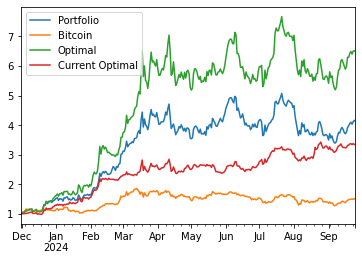

In [45]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [46]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

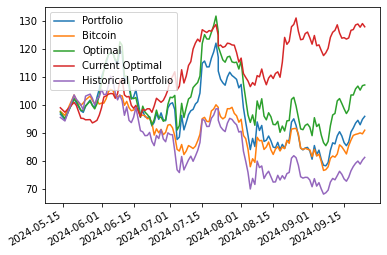

In [47]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [48]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-15,86.595562,83.895897,98.669467,124.070279,73.650513
2024-09-16,85.531850,82.583217,96.993746,123.565107,72.860240
2024-09-17,86.861447,85.509833,98.367264,123.972541,74.288060
2024-09-18,90.419570,87.535703,103.619948,126.697209,76.578064
2024-09-19,91.844879,89.203528,103.613011,126.960344,78.100735
2024-09-20,93.570719,89.561420,105.791256,128.603083,79.257782
2024-09-21,94.591121,89.770777,106.794753,128.940524,80.041385
2024-09-22,92.999258,90.095833,105.354590,127.800912,78.955810
2024-09-23,94.933946,89.756842,106.959266,129.094910,80.384976
2024-09-24,95.996577,91.054949,107.202929,127.954215,81.362290


## Volatilities

In [49]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.692606
dtype: float64

In [50]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.55176
dtype: float64

In [51]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.598968
Bitcoin            0.442724
Optimal            0.693732
Current Optimal    0.430334
dtype: float64

In [52]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.24610545729851008

## Risk Contribution

In [53]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.111431,0.089760,0.020190,0.029226,0.004067,0.025159
BTCUSDT,0.196694,0.400000,0.059879,0.164665,0.065163,0.099502
JASMYUSDT,0.032330,0.023144,0.005567,0.013806,0.001316,0.012490
OMUSDT,8.538753,0.444871,0.901520,0.757142,0.655597,0.101545
PEPEUSDT,0.085761,0.042225,0.012844,0.035161,0.006144,0.029017


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.098614,0.266734,0.299108,0.50957,0.445425,0.064144
TRXUSDT,0.122844,0.733266,0.700892,0.49043,0.426286,0.064144


In [55]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.011355,0.28,0.255150,0.179830,0.044526,0.135304
OMUSDT,0.103518,0.28,0.364252,0.354255,0.190713,0.163542
JASMYUSDT,-0.004331,0.15,0.138351,0.215158,0.070979,0.144179
SOLUSDT,-0.013895,0.14,0.119770,0.140819,0.029112,0.111707
ETHUSDT,-0.017354,0.09,0.068996,0.070355,0.008074,0.062281
TRXUSDT,0.006701,0.04,0.044355,0.006184,0.000493,0.005691
BBUSDT,-0.010392,0.02,0.009125,0.033399,0.002679,0.030720


# Value At Risk

## Historical

In [56]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.057559878771026786, -0.08265878199493268)

In [57]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05140653764205467, -0.0709849850141754)

In [58]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [59]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.015666
OMUSDT      -0.007549
JASMYUSDT   -0.007218
SOLUSDT     -0.009521
ETHUSDT     -0.007823
TRXUSDT     -0.000926
BBUSDT      -0.002220
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050923
Name: 2024-08-27 00:00:00, dtype: float64

In [60]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.012905
OMUSDT      -0.021927
JASMYUSDT   -0.014627
SOLUSDT     -0.010846
ETHUSDT     -0.005388
TRXUSDT     -0.000788
BBUSDT      -0.001997
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068477
dtype: float64

## Parametric

In [61]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07188171809375914, -0.09213248840184406)

In [62]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05717116208316011, -0.07327762283973581)

## Multivariate

In [63]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06549523109383072, -0.08307786847591407)

In [64]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.055985896736923876, -0.06995033219693114)

In [65]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.011109
OMUSDT      -0.018356
JASMYUSDT   -0.011798
SOLUSDT     -0.008330
ETHUSDT     -0.004054
TRXUSDT     -0.000298
BBUSDT      -0.001926
Portfolio   -0.055871
dtype: float64

## Copulas

### Gaussian Copula

In [66]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06462586989168638, -0.08242279600642578)

In [67]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0559413571010929, -0.07044453784082477)

In [68]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010080
OMUSDT      -0.019589
JASMYUSDT   -0.011283
SOLUSDT     -0.008381
ETHUSDT     -0.004299
TRXUSDT     -0.000393
BBUSDT      -0.001827
Portfolio   -0.055853
dtype: float64

### Student Copula

In [69]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06483189288763508, -0.08380733184981706)

In [70]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05742550835992502, -0.07337961208119666)

In [71]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010749
OMUSDT      -0.020084
JASMYUSDT   -0.011232
SOLUSDT     -0.008454
ETHUSDT     -0.004252
TRXUSDT     -0.000181
BBUSDT      -0.002028
Portfolio   -0.056979
dtype: float64

### Gumbel Copula

In [72]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12302891822349657, -0.174732333397741)

In [73]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07114160217358402, -0.09782851501964589)

In [74]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.008568
OMUSDT      -0.044637
JASMYUSDT   -0.012494
SOLUSDT     -0.003462
ETHUSDT     -0.001162
TRXUSDT      0.000076
BBUSDT      -0.000025
Portfolio   -0.070273
dtype: float64

### Monte Carlo

In [75]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [76]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07340100002744214, -0.0905905237833522)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05863171254455693, -0.07272306210502504)

In [78]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.010621
OMUSDT      -0.020030
JASMYUSDT   -0.012666
SOLUSDT     -0.008582
ETHUSDT     -0.004300
TRXUSDT     -0.000330
BBUSDT      -0.001643
Portfolio   -0.058172
dtype: float64

## VaR Violation

In [79]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057012,-0.102330,-0.086653,-0.023541
2024-01-15,-0.057012,-0.102326,-0.086105,0.018740
2024-01-16,-0.057012,-0.102821,-0.086537,0.055680
2024-01-17,-0.057012,-0.105119,-0.087654,-0.034094
2024-01-18,-0.057012,-0.107044,-0.092794,-0.031689
...,...,...,...,...
2024-09-21,-0.042315,-0.079484,-0.072628,0.009486
2024-09-22,-0.042315,-0.072639,-0.073135,-0.013485
2024-09-23,-0.042315,-0.072834,-0.069103,0.015231
2024-09-24,-0.042315,-0.071490,-0.066864,0.002278


In [80]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031638,-0.085290,-0.078055,-0.017777
2024-05-29,-0.028927,-0.082375,-0.073981,-0.010068
2024-05-30,-0.028927,-0.071479,-0.065357,0.038500
2024-05-31,-0.028927,-0.070601,-0.061437,0.028058
2024-06-01,-0.028927,-0.071935,-0.061917,0.041604
...,...,...,...,...
2024-09-21,-0.025571,-0.052249,-0.039361,0.010905
2024-09-22,-0.025571,-0.054498,-0.043179,-0.016829
2024-09-23,-0.025571,-0.054742,-0.041054,0.020803
2024-09-24,-0.025571,-0.047346,-0.037960,0.011193


<AxesSubplot:>

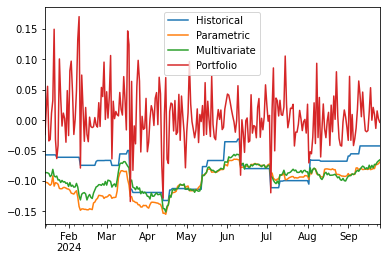

In [81]:
var_data.plot()

<AxesSubplot:>

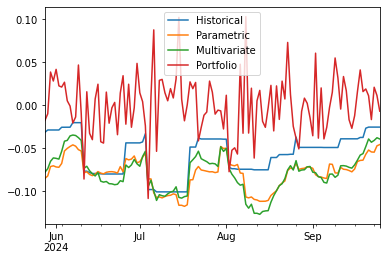

In [82]:
current_var_data.plot()

In [83]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.019531,0.011719,0.011719
Kupiec Stat,6.44746,11.284704,11.284704
P-value,0.011111,0.000781,0.000781


In [84]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057851,0.024793,0.024793
Kupiec Stat,0.149799,1.971544,1.971544
P-value,0.698727,0.160284,0.160284


## Principal Component Analysis

### Historical PCA

In [85]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79014504, 0.06588289, 0.05380773, 0.04583752, 0.04432682])

In [86]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.013956
ADAUSDT     0.014267
ALGOUSDT    0.015735
APTUSDT     0.015139
ARBUSDT     0.015266
              ...   
WLDUSDT     0.021432
XECUSDT     0.015220
XLMUSDT     0.009519
XRPUSDT     0.009129
XTZUSDT     0.014314
Name: PC1, Length: 65, dtype: float64

<AxesSubplot:>

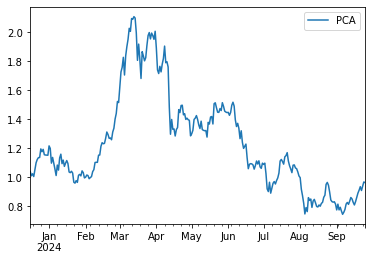

In [87]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

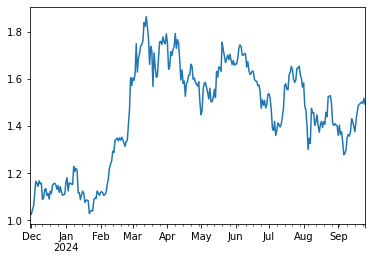

In [88]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [89]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
SANDUSDT     0.309068
XTZUSDT      0.334502
ADAUSDT      0.336795
ALGOUSDT     0.346877
               ...   
PEPEUSDT     0.993403
FLOKIUSDT    1.004518
WLDUSDT      1.038247
CKBUSDT      1.149990
OMUSDT       1.312752
Length: 66, dtype: float64

<AxesSubplot:>

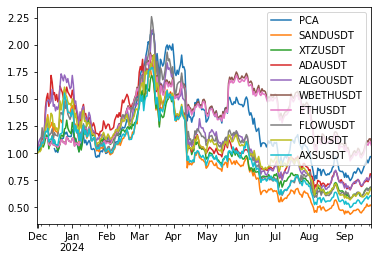

In [90]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

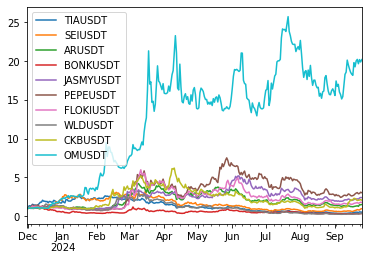

In [91]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [92]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66792923, 0.14040465, 0.0881729 , 0.07119843, 0.0322948 ])

In [93]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063997
OMUSDT       0.100503
JASMYUSDT    0.154803
SOLUSDT      0.103805
ETHUSDT      0.086835
TRXUSDT      0.014690
BBUSDT       0.245095
BNBUSDT      0.068426
PEPEUSDT     0.161846
Name: PC1, dtype: float64

<AxesSubplot:>

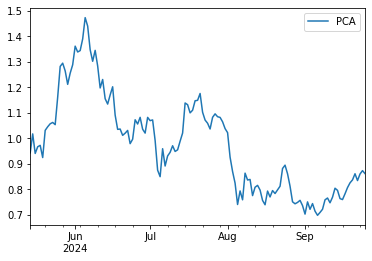

In [94]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

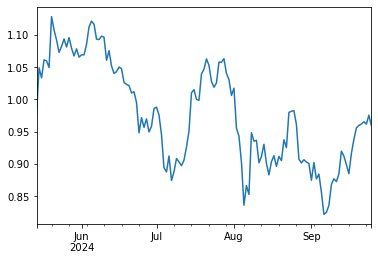

In [95]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [96]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.328995
SOLUSDT      0.343143
BNBUSDT      0.362245
BTCUSDT      0.363505
JASMYUSDT    0.423860
PEPEUSDT     0.457097
OMUSDT       0.535295
TRXUSDT      0.540429
BBUSDT       0.619380
dtype: float64

<AxesSubplot:>

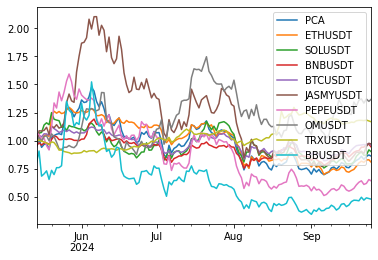

In [97]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [98]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.935192
BBUSDT       1.660268
JASMYUSDT    1.279452
SOLUSDT      1.164268
BTCUSDT      1.000000
OMUSDT       0.987128
ETHUSDT      0.955393
BNBUSDT      0.671962
TRXUSDT      0.278784
Name: BTCUSDT, dtype: float64

In [99]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.549521
BBUSDT       1.491927
JASMYUSDT    1.136493
BTCUSDT      1.000000
SOLUSDT      0.956601
ETHUSDT      0.935935
BNBUSDT      0.683507
OMUSDT       0.173150
TRXUSDT     -0.094711
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [100]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.0,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.000000,0.625881,0.150844,0.000000,0.0,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.000000,0.182521,0.000000,0.000000,0.0,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.414537,0.133222,0.000000,0.111977,0.0,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.0,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.000000,0.435173,0.000000,0.000000,0.0,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.287486,0.000000,0.000000,0.0,0.000000,0.712514,0.000000,0.000000


In [101]:
(rolling_optimization>0.25).sum()

BTCUSDT      1
OMUSDT       3
JASMYUSDT    2
SOLUSDT      0
ETHUSDT      0
TRXUSDT      5
BBUSDT       1
BNBUSDT      0
PEPEUSDT     1
dtype: int64

In [102]:
pd.read_excel('PnL Binance.xlsx')

,Date,Daily PnL,Cumulative Pnl,%
0,2024-09-25,-19.25,-321.89,-0.1367
1,2024-09-24,20.90,-302.65,-0.1285
2,2024-09-23,31.10,-323.55,-0.1374
3,2024-09-22,-23.78,-354.64,-0.1506
4,2024-09-21,17.09,-330.86,-0.1405
...,...,...,...,...
137,2024-05-11,2.89,0.82,0.0023
138,2024-05-10,-3.56,-2.07,-0.0059
139,2024-05-09,2.43,1.49,0.0107
140,2024-05-08,-1.62,-0.94,-0.0134
